#  Gamma/neutron discrimination based on ML

- Workflow based on R. S. Molina, I. R. Morales, M. L. Crespo, V. G. Costa, S. Carrato and G. Ramponi, "An End-to-End Workflow to Efficiently Compress and Deploy DNN Classifiers on SoC/FPGA", in IEEE Embedded Systems Letters, vol. 16, no. 3, pp. 255-258, Sept. 2024, doi: 10.1109/LES.2023.3343030.

- Code adapted from the official repository of  "An End-to-End Workflow to Efficiently Compress and Deploy DNN Classifiers on SoC/FPGA"

- Using open dataset from: https://doi.org/10.5281/zenodo.8037058


### Importacion de librerias

In [1]:
#MLab UDMA library
import udma 

import matplotlib.pyplot as plt
from time import sleep

In [2]:
# Length of the input signal 
TRACE_LEN = 161

# Input registers
CB_INFERENCE_REG = 2 # Inference result
CB_FIFO_REG = 3 # Inference result
CB_LEDS_REG = 4

### PYNQ Connection

In [3]:
#IP_ADDRESS = 'XXX.XXX.XXX.XXX' # Set your ZedBoard IP Address here
IP_ADDRESS = '192.168.1.10' 
IP_PORT = 7 

In [4]:
pynq = udma.UDMA_CLASS(IP_ADDRESS, IP_PORT)

In [5]:
connectionStatus = 0
while(connectionStatus == 0):
    connectionStatus = pynq.connect()
    sleep(1)

In [6]:
pynq.log(0)

[(5,), 0]

In [7]:
 # Function definition: used to clear out FIFO contents prior to read any value
def clearInFifo(udmaInstance):
    CB_CLEAR_INFIFO = 37
    # CB_CLEAR_INFIFO = 17
    udmaInstance.write_reg(CB_CLEAR_INFIFO, 1)
    udmaInstance.write_reg(CB_CLEAR_INFIFO, 0)

In [8]:
# Gamma
# Expected value: 5
signal = [402,401,401,402,401,403,402,403,403,403,404,403,403,403,403,402,400,399,398,396,394,392,390,389,387,385,384,383,382,380,379,378,378,377,377,375,374,373,374,372,374,373,373,371,373,372,371,370,371,370,369,369,369,368,368,367,367,366,367,365,365,364,365,364,365,364,362,361,361,361,360,361,362,360,361,360,360,358,359,358,358,356,358,357,356,356,355,355,354,354,354,354,354,353,353,352,352,351,352,352,351,352,351,351,351,352,351,351,352,351,351,352,352,351,352,352,352,351,351,350,351,351,351,350,350,350,350,350,349,349,349,349,349,349,347,349,348,347,348,346,347,347,348,348,348,348,348,348,348,348,348,349,348,349,349,349,348,349,347,347,346]

# signal = [386, 387, 385, 386, 386, 386, 386, 386, 386, 385, 386, 385, 385, 382, 381, 378, 375, 373, 370, 366, 363, 360, 355, 351, 346, 341, 336, 329, 324, 318, 313, 307, 301, 295, 291, 285, 281, 274, 270, 265, 259, 255, 250, 245, 240, 236, 230, 227, 222, 217, 213, 210, 205, 200, 198, 193, 190, 186, 183, 179, 176, 172, 168, 166, 163, 161, 158, 156, 153, 150, 147, 145, 143, 140, 138, 135, 135, 131, 130, 127, 126, 123, 121, 117, 116, 115, 112, 111, 108, 106, 104, 103, 101, 100, 98, 96, 96, 92, 93, 90, 91, 89, 89, 88, 88, 88, 87, 86, 86, 85, 84, 84, 84, 82, 82, 81, 81, 81, 79, 77, 77, 75, 75, 73, 73, 73, 72, 70, 70, 69, 68, 67, 66, 66, 65, 64, 63, 62, 63, 62, 61, 60, 59, 59, 58, 59, 59, 59, 58, 59, 57, 57, 58, 58, 57, 56, 57, 56, 55, 56, 57]


# Neutron
# Expected value: 3
#signal = [404,405,404,405,404,404,405,405,405,404,405,403,404,404,404,404,402,400,397,394,392,386,381,376,371,365,359,354,349,343,337,331,324,318,312,305,298,295,286,283,276,273,268,263,259,255,249,243,240,236,232,227,225,220,218,214,211,208,204,202,198,194,191,188,185,181,179,176,173,171,167,165,163,158,158,154,152,149,146,144,141,141,137,136,132,132,129,127,125,123,121,119,119,116,114,112,111,109,108,105,104,103,102,100,98,96,95,93,92,90,89,88,87,86,84,83,81,81,79,79,76,76,75,74,72,72,71,69,69,69,69,68,69,67,68,66,66,65,65,65,64,66,64,64,64,64,64,63,63,64,62,62,61,61,60,60,59,59,59,58,59]


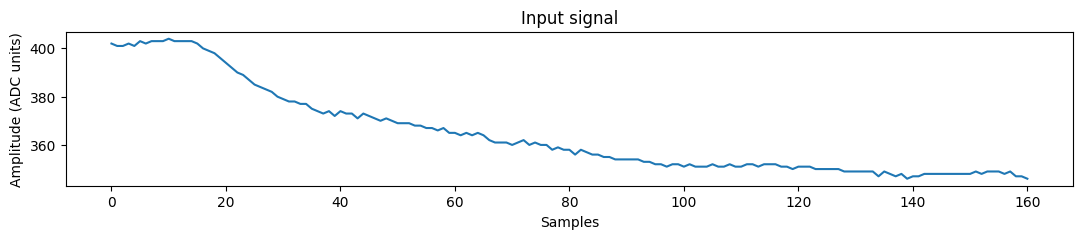

In [9]:
fig = plt.figure(figsize=(13,2))
plt.plot(signal)
plt.title("Input signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude (ADC units)")
plt.show()

### Interaction with ComBlock to send the signal and receive the inference result

In [10]:
# Clear input FIFO contents to get the latest data from the FIR filter output
clearInFifo(pynq)

In [11]:
# Initialize HLS IP core
pynq.write_reg(reg=1, data=0)
pynq.write_reg(reg=1, data=1)

[(1, 0), 0]

In [12]:
# Initialize HLS IP core
pynq.write_reg(reg=CB_LEDS_REG, data=4)

[(1, 0), 0]

In [13]:
# Initialize HLS IP core
pynq.write_reg(reg=CB_FIFO_REG, data=0)

[(1, 0), 0]

In [14]:
# Writing to ComBlock the signal to be used as input for the inference IP core
# signal should be array-type

pynq.write_fifo(length=len(signal), Txdata=signal)#[0] # <--- This is the signal variable that will be sent
pynq.write_reg(reg=2, data=1)
pynq.write_reg(reg=2, data=0)

[(1, 0), 0]

### Inference result

In [15]:
 # Read inference result
pynq.read_reg(reg=CB_INFERENCE_REG)[1][0]

3

[402, 401, 401, 402, 401, 403, 402, 403, 403, 403, 404, 403, 403, 403, 403, 402, 400, 399, 398, 396, 394, 392, 390, 389, 387, 385, 384, 383, 382, 380, 379, 378, 378, 377, 377, 375, 374, 373, 374, 372, 374, 373, 373, 371, 373, 372, 371, 370, 371, 370, 369, 369, 369, 368, 368, 367, 367, 366, 367, 365, 365, 364, 365, 364, 365, 364, 362, 361, 361, 361, 360, 361, 362, 360, 361, 360, 360, 358, 359, 358, 358, 356, 358, 357, 356, 356, 355, 355, 354, 354, 354, 354, 354, 353, 353, 352, 352, 351, 352, 352, 351, 352, 351, 351, 351, 352, 351, 351, 352, 351, 351, 352, 352, 351, 352, 352, 352, 351, 351, 350, 351, 351, 351, 350, 350, 350, 350, 350, 349, 349, 349, 349, 349, 349, 347, 349, 348, 347, 348, 346, 347, 347, 348, 348, 348, 348, 348, 348, 348, 348, 348, 349, 348, 349, 349, 349, 348, 349, 347, 347, 346]
161
(402, 401, 401, 402, 401, 403, 402, 403, 403, 403, 404, 403, 403, 403, 403, 402, 400, 399, 398, 396, 394, 392, 390, 389, 387, 385, 384, 383, 382, 380, 379, 378, 378, 377, 377, 375, 374, 373,

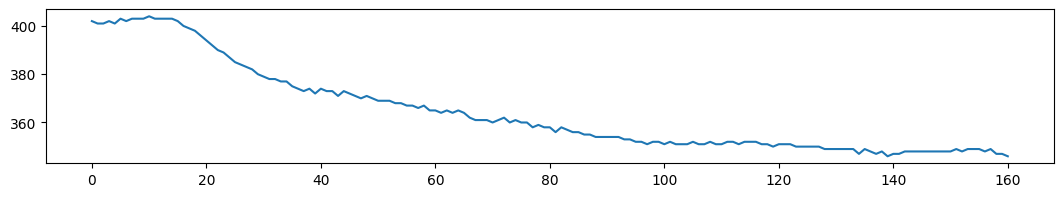

In [16]:
test = pynq.read_fifo(len(signal))[1]

plt.figure(figsize=(13,2))
plt.plot(test)
print(signal)
print(len(signal))
print(test)

# Evaluacion de datos de test

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

import pandas as pd

In [18]:
# Cargar el archivo test.csv
df = pd.read_csv('test_2.csv')
df = shuffle(df)

# Separar señales y etiquetas
X_signals = df.drop('class', axis=1)   # Todas las columnas menos 'class'
y_labels = df['class']                 # Solo la columna 'class'

# Ejemplo: obtener la primera señal y su etiqueta
signal = X_signals.iloc[0].values.tolist()      # Señal como array
label = y_labels.iloc[0]                        # Etiqueta

print("Primera señal:", signal)
print("Etiqueta:", label)

Primera señal: [504, 504, 503, 504, 504, 505, 504, 504, 504, 504, 504, 503, 503, 503, 502, 502, 501, 499, 498, 492, 489, 484, 479, 473, 466, 461, 452, 447, 440, 434, 427, 421, 414, 408, 401, 394, 388, 382, 376, 370, 363, 358, 351, 346, 341, 336, 330, 325, 319, 316, 312, 308, 304, 300, 297, 294, 290, 288, 286, 283, 281, 278, 275, 270, 267, 263, 259, 256, 252, 251, 247, 246, 243, 240, 239, 234, 232, 229, 227, 225, 224, 222, 221, 218, 215, 214, 211, 211, 206, 206, 203, 202, 200, 198, 197, 194, 193, 192, 190, 189, 189, 187, 185, 183, 181, 180, 178, 177, 177, 177, 174, 175, 174, 173, 171, 171, 169, 168, 169, 167, 168, 167, 168, 167, 167, 166, 164, 163, 162, 161, 160, 161, 159, 160, 159, 158, 156, 156, 156, 154, 153, 152, 152, 152, 151, 151, 151, 151, 152, 153, 153, 154, 152, 151, 151, 151, 150, 149, 149, 149, 149]
Etiqueta: 1


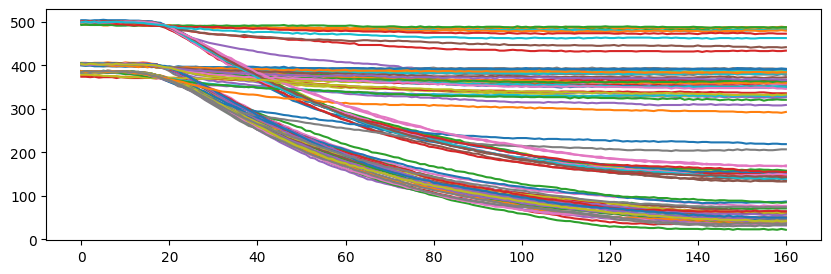

In [19]:
plt.figure(figsize=(10,3))

for i in range(0,len(X_signals)):
    plt.plot(X_signals.iloc[i].values.tolist())

In [20]:
predic = []
specte = []

for i in range(0,len(X_signals)):

    signal = X_signals.iloc[i].values.tolist()      # Señal como array
    specte.append(y_labels.iloc[i])

    pynq.write_fifo(length=len(signal), Txdata=signal)[0] # <--- This is the signal variable that will be sent
    pynq.write_reg(reg=2, data=1)
    pynq.write_reg(reg=2, data=0)

    result = pynq.read_reg(reg=CB_INFERENCE_REG)[1][0]
    if result == 3:
        predic.append(1)
    elif result == 5:
        predic.append(0)
    else:
        predic.append(2)



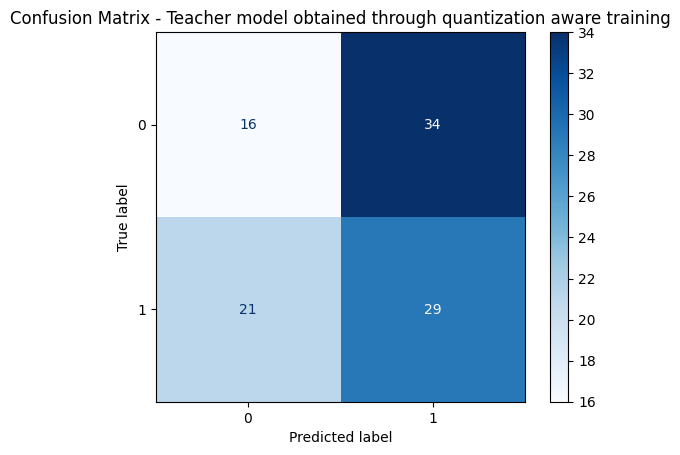

In [21]:
cm = confusion_matrix(specte, predic)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix - Teacher model obtained through quantization aware training')
plt.show()

### Datos de Test

In [22]:
# Cargar el archivo test.csv
df = pd.read_csv('test.csv')
df = shuffle(df)

# Separar señales y etiquetas
X_signals = df.drop('class', axis=1)   # Todas las columnas menos 'class'
y_labels = df['class']                 # Solo la columna 'class'

# Ejemplo: obtener la primera señal y su etiqueta
signal = X_signals.iloc[0].values.tolist()      # Señal como array
label = y_labels.iloc[0]                        # Etiqueta

print("Primera señal:", signal)
print("Etiqueta:", label)

Primera señal: [404, 404, 403, 403, 403, 404, 404, 404, 404, 405, 405, 403, 404, 404, 403, 402, 403, 402, 399, 396, 392, 387, 382, 376, 371, 366, 360, 355, 350, 343, 337, 330, 325, 319, 313, 308, 301, 297, 291, 285, 279, 275, 270, 264, 261, 256, 251, 247, 242, 238, 233, 227, 223, 218, 213, 209, 204, 200, 195, 192, 188, 185, 181, 179, 176, 173, 170, 168, 165, 162, 160, 156, 154, 150, 149, 147, 145, 142, 141, 139, 136, 133, 129, 128, 124, 122, 120, 117, 115, 113, 111, 108, 107, 103, 102, 100, 98, 96, 94, 93, 91, 91, 88, 88, 85, 85, 84, 83, 81, 79, 78, 76, 76, 73, 74, 72, 73, 70, 70, 69, 68, 67, 66, 66, 65, 66, 65, 65, 62, 61, 60, 59, 58, 57, 57, 55, 54, 54, 53, 52, 51, 50, 49, 49, 49, 48, 47, 47, 46, 47, 45, 46, 44, 45, 45, 44, 45, 44, 45, 44, 43]
Etiqueta: 1


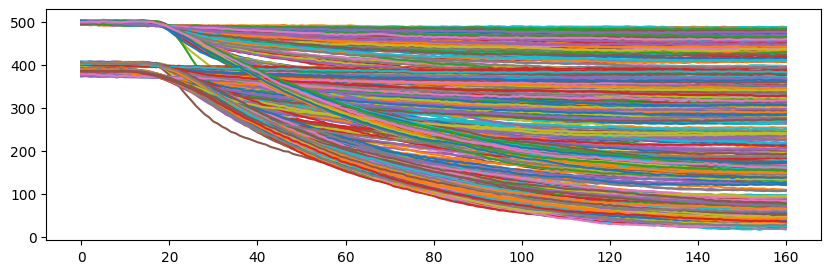

In [23]:
plt.figure(figsize=(10,3))

for i in range(0,len(X_signals)):
    plt.plot(X_signals.iloc[i].values.tolist())

In [24]:
predic = []
specte = []

for i in range(0,len(X_signals)):

    signal = X_signals.iloc[i].values.tolist()      # Señal como array
    specte.append(y_labels.iloc[i])

    pynq.write_fifo(length=len(signal), Txdata=signal)[0] # <--- This is the signal variable that will be sent
    pynq.write_reg(reg=2, data=1)
    pynq.write_reg(reg=2, data=0)

    result = pynq.read_reg(reg=CB_INFERENCE_REG)[1][0]
    if result == 3:
        predic.append(1)
    elif result == 5:
        predic.append(0)
    else:
        predic.append(2)


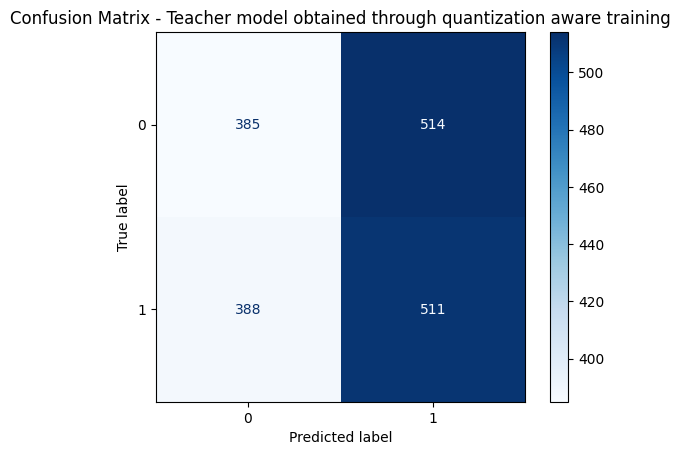

In [25]:
cm = confusion_matrix(specte, predic)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix - Teacher model obtained through quantization aware training')
plt.show()